# Big Data project

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,expr,avg,sum,min,max,countDistinct,to_date,when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator,RegressionEvaluator
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


## Start spaek session

In [5]:
spark = SparkSession.builder \
    .appName("Read E-commerce Datasets") \
    .getOrCreate()

25/05/23 16:29:00 WARN Utils: Your hostname, eltras resolves to a loopback address: 127.0.1.1; using 192.168.1.3 instead (on interface wlp2s0)
25/05/23 16:29:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/23 16:29:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## get datasets

In [6]:
print("===== Dataset 1: e-shop-clothing-2008 =====")
eshop_df = spark.read.option("header", "true") \
                     .option("sep", ";") \
                     .csv("hdfs://localhost:9000/Bigdatasets/e-shop-clothing-2008.csv")

print("e-shop-clothing-2008.csv")
eshop_df.show(5)
eshop_df.printSchema()

print("===== Dataset 2: Online Retail II =====")
retail2_df = spark.read.option("header", "true") \
                       .csv("hdfs://localhost:9000/Bigdatasets/online_retail_II.csv")

print("online_retail_II.csv")
retail2_df.show(5)
retail2_df.printSchema()

print("===== Dataset 3: Online Retail =====")
retail_df = spark.read.option("header", "true") \
                      .csv("hdfs://localhost:9000/Bigdatasets/Online-Retail.csv")

print("Online-Retail.csv")
retail_df.show(5)
retail_df.printSchema()

===== Dataset 1: e-shop-clothing-2008 =====


e-shop-clothing-2008.csv
+----+-----+---+-----+-------+----------+----------------------+-----------------------+------+--------+-----------------+-----+-------+----+
|year|month|day|order|country|session ID|page 1 (main category)|page 2 (clothing model)|colour|location|model photography|price|price 2|page|
+----+-----+---+-----+-------+----------+----------------------+-----------------------+------+--------+-----------------+-----+-------+----+
|2008|    4|  1|    1|     29|         1|                     1|                    A13|     1|       5|                1|   28|      2|   1|
|2008|    4|  1|    2|     29|         1|                     1|                    A16|     1|       6|                1|   33|      2|   1|
|2008|    4|  1|    3|     29|         1|                     2|                     B4|    10|       2|                1|   52|      1|   1|
|2008|    4|  1|    4|     29|         1|                     2|                    B17|     6|       6|                2| 

# Clean e-shop-clothing-2008 Dataset

In [7]:
eshop_clean = eshop_df.dropna(subset=["session ID", "price"])
eshop_clean = eshop_clean.withColumn("year", col("year").cast("int")) \
                         .withColumn("month", col("month").cast("int")) \
                         .withColumn("day", col("day").cast("int")) \
                         .withColumn("price", col("price").cast("double"))

eshop_clean.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- order: string (nullable = true)
 |-- country: string (nullable = true)
 |-- session ID: string (nullable = true)
 |-- page 1 (main category): string (nullable = true)
 |-- page 2 (clothing model): string (nullable = true)
 |-- colour: string (nullable = true)
 |-- location: string (nullable = true)
 |-- model photography: string (nullable = true)
 |-- price: double (nullable = true)
 |-- price 2: string (nullable = true)
 |-- page: string (nullable = true)



# Clean online retail II dataset

In [8]:
retail2_clean = retail2_df.dropna(subset=["Invoice", "Price", "Customer ID"])
retail2_clean = retail2_clean.withColumn("Quantity", col("Quantity").cast("int")) \
                             .withColumn("Price", col("Price").cast("double")) \
                             .withColumn("Customer ID", col("Customer ID").cast("int"))
retail2_clean = retail2_clean.withColumn("InvoiceDate", col("InvoiceDate").cast("timestamp"))
retail2_clean.printSchema()


root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Country: string (nullable = true)



# clean Online-Retail dataset

In [9]:
retail_clean = retail_df.dropna(subset=["InvoiceNo", "UnitPrice", "CustomerID"])
retail_clean = retail_clean.withColumn("Quantity", col("Quantity").cast("int")) \
                           .withColumn("UnitPrice", col("UnitPrice").cast("double")) \
                           .withColumn("CustomerID", col("CustomerID").cast("int")) \
                           .withColumn("InvoiceDate", col("InvoiceDate").cast("timestamp"))

retail_clean.printSchema()


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



### joins

Merge retail_clean with retail2_clean
Provided the Customer ID and Stock Code are the same

Objective: Analyze the behavior of the same customer across both periods

In [10]:
retail_joined = retail2_clean.alias("r2") \
    .join(retail_clean.alias("r1"),
          (col("r1.CustomerID") == col("r2.Customer ID")) &
          (col("r1.StockCode") == col("r2.StockCode")),
          how="inner")

retail_joined.select("r1.CustomerID", "r1.StockCode", "r1.Quantity", "r2.Quantity").show(5)


+----------+---------+--------+--------+
|CustomerID|StockCode|Quantity|Quantity|
+----------+---------+--------+--------+
|     17850|   85123A|       6|      12|
|     17850|   85123A|       6|       6|
|     17850|   85123A|       6|       6|
|     17850|   85123A|       6|      12|
|     17850|   85123A|       6|       6|
+----------+---------+--------+--------+
only showing top 5 rows



Linking e-shop to retail2 (assuming session ID ↔ customer ID approximately)
Analyzing browsing versus purchasing behavior. The linking here is approximate or imaginary (if there are no actual shared IDs).

In [11]:
eshop_with_retail = eshop_clean.alias("e") \
    .join(retail2_clean.alias("r"),
          col("e.session ID") == col("r.Customer ID"),
          how="inner")
eshop_with_retail.select(
    col("e.session ID"),
    col("e.page 1 (main category)"),
    col("e.price").alias("eshop_price"),
    col("r.Quantity"),
    col("r.Country")
).show(5)

+----------+----------------------+-----------+--------+--------------+
|session ID|page 1 (main category)|eshop_price|Quantity|       Country|
+----------+----------------------+-----------+--------+--------------+
|     13085|                     2|       52.0|      12|United Kingdom|
|     13085|                     2|       67.0|      12|United Kingdom|
|     13085|                     2|       57.0|      12|United Kingdom|
|     13085|                     2|       52.0|      12|United Kingdom|
|     13085|                     2|       67.0|      12|United Kingdom|
+----------+----------------------+-----------+--------+--------------+
only showing top 5 rows



EDA on e-shop-clothing-2008.csv

In [12]:
print("Basic Summary for E-Shop")
eshop_clean.describe().show()

Basic Summary for E-Shop


25/05/23 16:30:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+------------------+------------------+------------------+------------------+----------------------+-----------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|                year|             month|               day|             order|           country|        session ID|page 1 (main category)|page 2 (clothing model)|            colour|          location| model photography|             price|           price 2|              page|
+-------+--------------------+------------------+------------------+------------------+------------------+------------------+----------------------+-----------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              165474|            165474|            165474|            165474|            165474|            165474|              

Number of rows + empty columns

In [13]:
print("Rows:", eshop_clean.count())
eshop_clean.select([col(c).isNull().alias(c) for c in eshop_clean.columns]).groupBy().sum().show()

Rows: 165474
++
||
++
||
++



Most visited pages/categories

In [14]:
eshop_clean.groupBy("page 1 (main category)").count().orderBy("count", ascending=False).show(10)

+----------------------+-----+
|page 1 (main category)|count|
+----------------------+-----+
|                     1|49742|
|                     4|38747|
|                     3|38577|
|                     2|38408|
+----------------------+-----+



Average prices


In [15]:
eshop_clean.select(avg("price")).show()

+------------------+
|        avg(price)|
+------------------+
|43.802506738218696|
+------------------+



EDA on online_retail_II.csv

In [16]:
print("Summary: Online Retail II")
retail2_clean.describe().show()

Summary: Online Retail II


+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|summary|           Invoice|         StockCode|         Description|          Quantity|            Price|       Customer ID|    Country|
+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|  count|            417534|            417534|              417534|            417534|           417534|            417534|     417534|
|   mean| 514760.7072394805| 30260.17164837453|                NULL|12.758814851006145|3.887547466794196|15360.645477973052|       NULL|
| stddev|14101.015473645713|20383.266257971816|                NULL|101.22042350285375|71.13179663753127|1680.8113157457149|       NULL|
|    min|            489434|             10002|  DOORMAT UNION J...|             -9360|              0.0|             12346|  Australia|
|    max|           C538164|           TE

empty rows

In [17]:
retail2_clean.select([col(c).isNull().alias(c) for c in retail2_clean.columns]).groupBy().sum().show()

++
||
++
||
++



The most buying countries

In [18]:
retail2_clean.groupBy("Country").count().orderBy("count", ascending=False).show(10)

+---------------+------+
|        Country| count|
+---------------+------+
| United Kingdom|379423|
|           EIRE|  8710|
|        Germany|  8129|
|         France|  5710|
|    Netherlands|  2769|
|          Spain|  1278|
|    Switzerland|  1187|
|        Belgium|  1054|
|       Portugal|  1024|
|Channel Islands|   906|
+---------------+------+
only showing top 10 rows



Invoice value (Quantity × Price)

In [19]:

retail2_clean = retail2_clean.withColumn("TotalAmount", expr("Quantity * Price"))
retail2_clean.select(avg("TotalAmount")).show()

+-----------------+
| avg(TotalAmount)|
+-----------------+
|19.99408089879953|
+-----------------+



EDA on Online-Retail.csv

In [20]:
print("Summary: Online Retail")
retail_clean.describe().show()

Summary: Online Retail


+-------+------------------+------------------+--------------------+-----------------+------------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|         Quantity|         UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+-----------------+------------------+------------------+-----------+
|  count|            406829|            406829|              406829|           406829|            406829|            406829|     406829|
|   mean| 560617.1266447864|27430.341352504624|                NULL|12.06130339774205|3.4604710185365297|15287.690570239585|       NULL|
| stddev|13106.167694741129|16403.570452626158|                NULL|248.6933700188249|  69.3151617232145|1713.6003033215961|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|           -80995|               0.0|             12346|  Australia|
|    max|           C581569|             

Countries

In [21]:
retail_clean.groupBy("Country").count().orderBy("count", ascending=False).show(10)

+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|361878|
|       Germany|  9495|
|        France|  8491|
|          EIRE|  7485|
|         Spain|  2533|
|   Netherlands|  2371|
|       Belgium|  2069|
|   Switzerland|  1877|
|      Portugal|  1480|
|     Australia|  1259|
+--------------+------+
only showing top 10 rows



Total price per invoice:

In [22]:
retail_clean = retail_clean.withColumn("TotalAmount", expr("Quantity * UnitPrice"))
retail_clean.groupBy("InvoiceNo") \
            .agg(sum("TotalAmount").alias("InvoiceTotal")) \
            .orderBy("InvoiceTotal", ascending=False) \
            .show(5)

+---------+------------------+
|InvoiceNo|      InvoiceTotal|
+---------+------------------+
|   581483|          168469.6|
|   541431|           77183.6|
|   556444|           38970.0|
|   567423|31698.159999999996|
|   556917|22775.930000000008|
+---------+------------------+
only showing top 5 rows



## Reporting for retail clean

In [23]:
retail_clean.select(
    countDistinct("InvoiceNo").alias("Total Invoices"),
    countDistinct("CustomerID").alias("Unique Customers"),
    min("InvoiceDate").alias("Start Date"),
    max("InvoiceDate").alias("End Date"),
    avg("UnitPrice").alias("Average Price")
).show(truncate=False)

+--------------+----------------+-------------------+-------------------+------------------+
|Total Invoices|Unique Customers|Start Date         |End Date           |Average Price     |
+--------------+----------------+-------------------+-------------------+------------------+
|22190         |4372            |2010-12-01 08:26:00|2011-12-09 12:50:00|3.4604710185365297|
+--------------+----------------+-------------------+-------------------+------------------+



Total purchase per country

In [24]:
retail_clean.groupBy("Country") \
    .agg(sum("TotalAmount").alias("Total Purchase")) \
    .orderBy("Total Purchase", ascending=False) \
    .show(10)

+--------------+------------------+
|       Country|    Total Purchase|
+--------------+------------------+
|United Kingdom|  6767873.39399998|
|   Netherlands|         284661.54|
|          EIRE|         250285.22|
|       Germany|221698.21000000005|
|        France| 196712.8400000001|
|     Australia|137077.26999999996|
|   Switzerland| 55739.39999999996|
|         Spain| 54774.58000000001|
|       Belgium|          40910.96|
|        Sweden|          36595.91|
+--------------+------------------+
only showing top 10 rows



Distribution chart by country (Top 10 countries in terms of purchase)

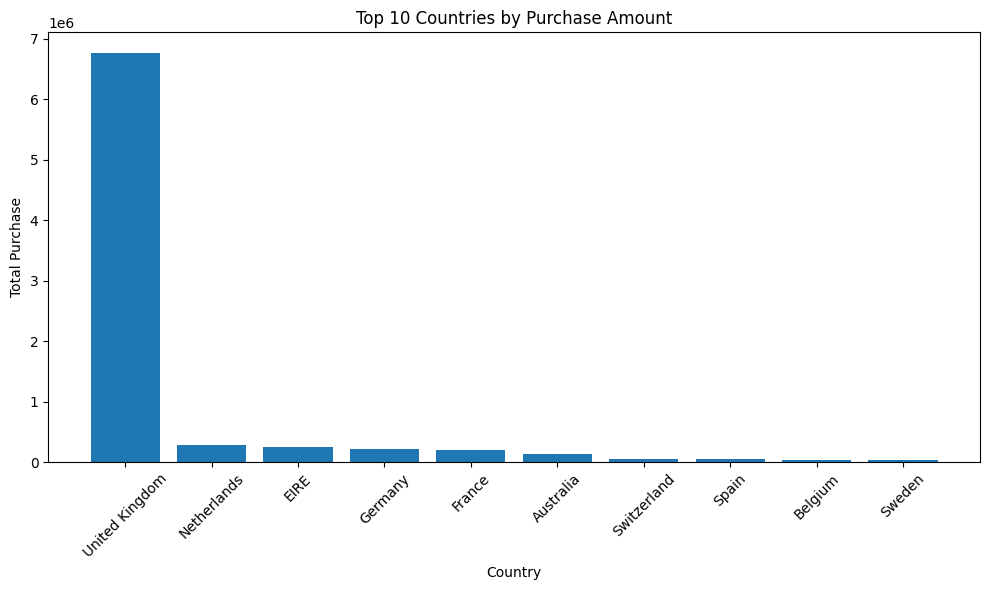

In [30]:
top_countries = retail_clean.groupBy("Country") \
    .agg(sum("TotalAmount").alias("Total Purchase")) \
    .orderBy("Total Purchase", ascending=False) \
    .limit(10) \
    .toPandas()

plt.figure(figsize=(10,6))
plt.bar(top_countries["Country"], top_countries["Total Purchase"])
plt.xticks(rotation=45)
plt.title("Top 10 Countries by Purchase Amount")
plt.xlabel("Country")
plt.ylabel("Total Purchase")
plt.tight_layout()
plt.show()

Charting the evolution of purchasing over time

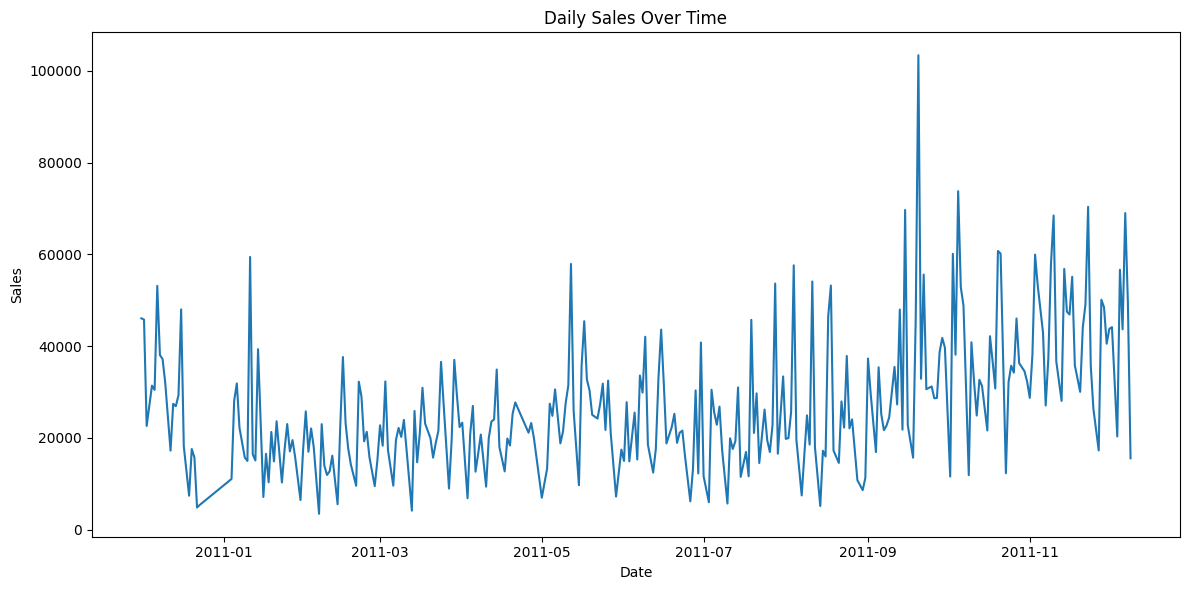

In [29]:
daily_sales = retail_clean.withColumn("Date", to_date("InvoiceDate")) \
    .groupBy("Date") \
    .agg(sum("TotalAmount").alias("Daily Sales")) \
    .orderBy("Date")
sales_pd = daily_sales.toPandas()

plt.figure(figsize=(12,6))
plt.plot(sales_pd["Date"], sales_pd["Daily Sales"])
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


Relation between variables

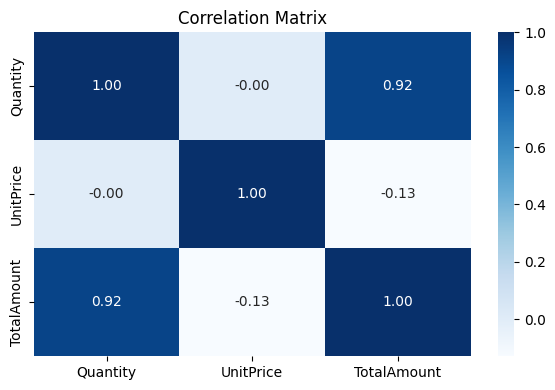

In [31]:
retail_clean = retail_clean.withColumn("TotalAmount", expr("Quantity * UnitPrice"))
num_df = retail_clean.select("Quantity", "UnitPrice", "TotalAmount").toPandas()


corr_matrix = num_df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


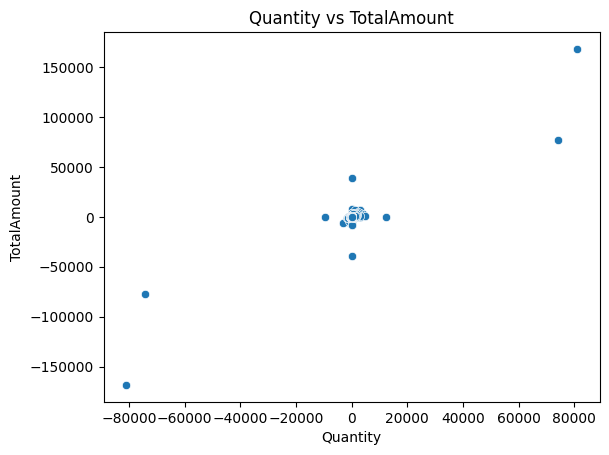

In [32]:
sns.scatterplot(data=num_df, x="Quantity", y="TotalAmount")
plt.title("Quantity vs TotalAmount")
plt.show()

ML section
1.Classification -->Predicting customer behavior

In [33]:
retail_class = retail_clean.withColumn("label", when(col("TotalAmount") > 200, 1).otherwise(0))
assembler = VectorAssembler(
    inputCols=["Quantity", "UnitPrice"],
    outputCol="features"
)
retail_class = assembler.transform(retail_class)
train, test = retail_class.randomSplit([0.7, 0.3], seed=42)
lr = LogisticRegression(featuresCol="features", labelCol="label")
model = lr.fit(train)
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions)
print(f"Logistic Regression AUC = {auc:.3f}")

25/05/23 16:35:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression AUC = 0.980


2.Regression --> Predicting the invoice value

In [34]:
retail_reg = retail_clean.select("Quantity", "UnitPrice", "TotalAmount")
assembler = VectorAssembler(inputCols=["Quantity", "UnitPrice"], outputCol="features")
retail_reg = assembler.transform(retail_reg)
train_r, test_r = retail_reg.randomSplit([0.7, 0.3], seed=42)
lr_model = LinearRegression(featuresCol="features", labelCol="TotalAmount")
model = lr_model.fit(train_r)
preds = model.transform(test_r)
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="TotalAmount", metricName="rmse")
rmse = evaluator.evaluate(preds)
print(f"Linear Regression RMSE = {rmse:.2f}")


25/05/23 16:35:42 WARN Instrumentation: [7ca134e6] regParam is zero, which might cause numerical instability and overfitting.
25/05/23 16:35:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression RMSE = 214.61


In [ ]:
retail_clean.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv("hdfs://localhost:9000/Bigdataresults/retail_clean_data.csv")
retail2_clean.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv("hdfs://localhost:9000/Bigdataresults/retail2_clean_data.csv")
eshop_clean.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv("hdfs://localhost:9000/Bigdataresults/eshop_clean_data.csv")